In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取数据集
# 读取数据集
train = pd.read_csv("merged_table.csv", header=None)
train.head(5)


,0,1,2,3,4,5,6,7,8,9,10
0,personid,clazzid,mean_col1,stddev_col1,max_col2,min_score,count,total_exam_number,activity_count_a,activity_count_b,c
1,28418748,8009011,105,NaN,105,105,1,1,160,228,0.701754386
2,28418748,9665081,90,7.071067812,100,80,5,9,160,228,0.701754386
3,28418748,6138412,61,NaN,61,61,1,1,160,228,0.701754386
4,28418748,5375163,60.5,55.86143571,100,21,2,2,160,228,0.701754386


In [2]:

# 选择第二行到最后一行，以及第三列到第十列的数据
x_train = train.iloc[1:, 2:11]
# 定义权重数组，每一列对应一个权重值
column_weights = [1.0, 0.5, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2,1.0]

x_train.head(5)

,2,3,4,5,6,7,8,9,10
1,105,NaN,105,105,1,1,160,228,0.701754386
2,90,7.071067812,100,80,5,9,160,228,0.701754386
3,61,NaN,61,61,1,1,160,228,0.701754386
4,60.5,55.86143571,100,21,2,2,160,228,0.701754386
5,58.33333333,48.56267428,100,5,3,3,160,228,0.701754386


In [3]:
# NaN填充
x_train[3].fillna(0, inplace=True)
# 标准化
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
weighted_x_train = x_train_scaled* column_weights
# 降维
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(weighted_x_train)

In [4]:
# Bi-KMeans 聚类算法实现
def bi_kmeans(data, k, num_iterations=5):
    n = data.shape[0]
    centroids = np.zeros((k, data.shape[1]))

    # 初始化质心，可以选择不同的初始化方法，这里随机选择 k 个数据点作为初始质心
    initial_centroids_idx = np.random.choice(n, k, replace=False)
    centroids = data[initial_centroids_idx]

    inertia = []  # 用于存储每次迭代后的惯性值

    for _ in range(num_iterations):
        # 分配每个样本点到最近的质心
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)

        # 计算惯性
        distances = np.linalg.norm(data - centroids[labels], axis=1)
        inertia.append(np.sum(distances ** 2))  # 计算并保存每次迭代的惯性值

        # 更新质心
        for j in range(k):
            centroids[j] = np.mean(data[labels == j], axis=0)

    return labels, centroids, inertia



In [5]:
predicted_labels, cluster_centers, inertia_values = bi_kmeans(x_train_pca, 4)

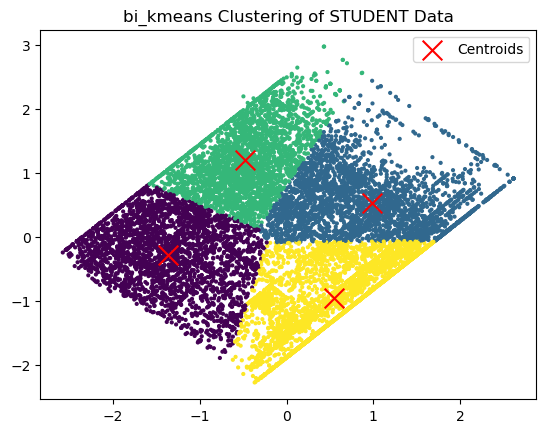

In [6]:
# 绘制聚类结果
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=predicted_labels, cmap='viridis', s=4)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('bi_kmeans Clustering of STUDENT Data')
plt.legend()
plt.show()


In [7]:
# 计算DB指数
db_index_values = metrics.davies_bouldin_score(x_train_pca, predicted_labels)
print(f"DB Index: {db_index_values}")

# 计算Dunn指数
def calculate_dunn_index(cluster_centers, labels, metric='euclidean'):
    num_clusters = len(cluster_centers)
    max_intra_cluster_distance = 0
    min_inter_cluster_distance = float('inf')

    for i in range(num_clusters):
        cluster_points = x_train_pca[labels == i]  # 获取第i个簇的数据点
        if len(cluster_points) == 0:
            continue

        intra_cluster_distance = metrics.pairwise_distances(cluster_points, metric=metric).max()
        if intra_cluster_distance > max_intra_cluster_distance:
            max_intra_cluster_distance = intra_cluster_distance

        for j in range(i + 1, num_clusters):
            other_cluster_points = x_train_pca[labels == j]  # 获取第j个簇的数据点
            inter_cluster_distance = metrics.pairwise_distances(cluster_points, other_cluster_points, metric=metric).min()
            if inter_cluster_distance < min_inter_cluster_distance:
                min_inter_cluster_distance = inter_cluster_distance

    dunn_index = min_inter_cluster_distance / max_intra_cluster_distance
    return dunn_index

dunn_index_values = calculate_dunn_index(cluster_centers, predicted_labels)
print(f"Dunn Index: {dunn_index_values}")

# 计算Inertia
print(f'Inertia: {inertia_values}')

# 计算轮廓系数
silhouette_score_values = metrics.silhouette_score(x_train_pca, predicted_labels)
print(f'Silhouette Score: {silhouette_score_values}')

# 计算Calinski-Harabasz指数
calinski_harabasz_score_values = metrics.calinski_harabasz_score(x_train_pca, predicted_labels)
print(f'Calinski-Harabasz Score: {calinski_harabasz_score_values}')

DB Index: 0.8645303902983859
Dunn Index: 0.0011602370358472559
Inertia: [24589.789777255814, 11042.450894233418, 9926.98008314108, 9310.211961288309, 8486.005571899379]
Silhouette Score: 0.36891333800368936
Calinski-Harabasz Score: 11666.821269473883


In [8]:
# 计算标准化值
normalized_inverted_scores = {}
weights = {
    'db_index': 0.25,
    'dunn_index': 0.25,
    'inertia': 0.15,
    'silhouette_score': 0.15,
    'calinski_harabasz_score': 0.20
}

# 计算归一化倒数
min_value = min(db_index_values, dunn_index_values, inertia_values[-1], silhouette_score_values, calinski_harabasz_score_values)
max_value = max(db_index_values, dunn_index_values, inertia_values[-1], silhouette_score_values, calinski_harabasz_score_values)

normalized_inverted_scores = {}
for metric_name, metric_value in {
    'db_index': db_index_values,
    'dunn_index': dunn_index_values,
    'inertia': inertia_values[-1],
    'silhouette_score': silhouette_score_values,
    'calinski_harabasz_score': calinski_harabasz_score_values
}.items():
    if min_value == max_value:
        normalized_inverted_scores[metric_name] = 0.0
    else:
        normalized_inverted_scores[metric_name] = (max_value - metric_value) / (max_value - min_value)

# 计算综合得分
composite_score = sum(normalized_inverted_scores[key] * weights[key] for key in weights)
print(f"Composite Score: {composite_score*100}")

Composite Score: 69.08724352195318


In [9]:
# 在数据集的第一行最后一列添加 'cluster' 字段
train.at[0, 11] = 'cluster_label'

# 将聚类标签添加到数据集的最后一列的第二行以下
train.iloc[1:, -1] = pd.Series(predicted_labels, name='11')


# 保存带有聚类标签的数据集为新的 CSV 文件
train.to_csv("merged_table_with_labels.csv", index=False)

